In [290]:
import pandas as pd
import numpy as np
import pickle as cpickle
import os.path
import tensorflow as tf
import keras.utils
from keras.callbacks import ModelCheckpoint
import re
from tensorflow.contrib import learn
from collections import OrderedDict
from collections import Counter
import h5py
from keras.models import load_model
from matplotlib import pyplot

#lyrics_file = "lyrics.txt"
lyrics_file = "lyric_qaurtaa"
#lyrics_file = "lyricaa"
#word_vectors_file = "word_vectors_5000.p"
embed_file = "glove.6B.50d.txt"
MAX_SENTENCE_LENGTH = 12


In [291]:
def clean_str( string, lower=True ):
    """
    Tokenization/string cleaning for the datasets.
    Taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    #Remove anything that is not a character, a digit, a bracket etc. from the string
    string = re.sub( r"[^A-Za-z0-9(),!?\'\`]"," ", string )
    #Add a space between the apostrophes so that they are not counted as a single word
    string = re.sub( r"\'s"," 's", string )
    string = re.sub( r"\'ve", " 've", string )
    string = re.sub( r"\'re", " 're", string )
    string = re.sub( r"\'d", " 'd", string )
    string = re.sub( r"\'ll", " 'll", string )
    string = re.sub( r"n\'t", " n't", string )
    string = re.sub( r",", " , ", string )
    string = re.sub( r"!", " ! ", string )
    string = re.sub( r"\(", " ( ", string )
    string = re.sub( r"\)", " ) ", string )
    string = re.sub( r"\?", " ? ", string )
    string = re.sub( r"\s{2,}"," ", string )

    result = string.strip()
    if lower:
        result = result.lower()

    return result

In [292]:
def loadLyrics( lyrics_file ):
    vocab_dict = {}
    lyrics_data = []
    embed_dict = load_embed_to_dict( embed_file )
    with open( lyrics_file ) as fp:
        for line in fp:
            words = line.split()
            filtered_arr = []
            for word in words:
                ts = clean_str( word )
                if ts != '':
                    ts = ts.split(' ')
                    for t in ts:
                        t = str(t)
                        if t not in embed_dict:
                            continue
                        vocab_dict[t] = vocab_dict.get(t,0) + 1
                        filtered_arr.append(t)
            lyrics_data.append(filtered_arr)
    return lyrics_data, vocab_dict


In [293]:
lyricsData, vocab_dict = loadLyrics( lyrics_file )

In [294]:
print(lyricsData[0:10], vocab_dict['jay'])

[['(', 'jay', 'z', ')'], ['motherfuckers'], ['say', 'that', 'foolish', 'i', 'only', 'talk', 'about', 'jewels', '(', 'bling', 'bling', ')'], ['do', 'you', 'fools', 'listen', 'to', 'music', 'or', 'do', 'you', 'just', 'skim', 'through', 'it', '?'], ['see', 'influenced', 'by', 'the', 'ghetto', 'you', 'ruined'], ['that', 'same', 'dude', 'you', 'gave', ',', 'i', 'made', "somethin'"], ['what', 'i', 'do', 'through', 'and', 'through', 'and'], ['i', 'give', 'you', 'the', 'news', 'with', 'a', 'twist', 'it', "'s", 'just', 'his', 'ghetto', 'point', 'of', 'view'], ['the', 'renegade', 'you', 'been', 'afraid'], ['i', 'penetrate', 'pop', 'culture', ',', 'bring', "'em", 'a', 'lot', 'closer', 'to', 'the', 'block', 'where', 'they']] 1035


In [295]:
def load_embed_to_dict( embed_file ):
    """
    Load the embedding vector for each word onto the ordered dictionary and return
    """
    ret = OrderedDict()
    for row in list(open(embed_file,"r").readlines()):
        fields = row.strip().split()
        word = fields[0]
        ret[word] = np.array(list(map(float, fields[1:])))

    return ret


In [296]:
def load_embeddings(embed_file, vocab_dict, dim, use_cache=True):
    #embeddings_cache_file = embeddings_file + ".cache.npy"
    #if use_cache and os.path.isfile(embeddings_cache_file):
    #    embeddings = np.load(embeddings_cache_file)
    #    return embeddings

    embed = np.array(np.random.randn(len(vocab_dict)+ 1, dim), dtype=np.float32)
    embed[0] = 0
    for word, vec in load_embed_to_dict(embed_file).items():
        #word = normalize(word)
        if word in vocab_dict:
            embed[vocab_dict[word]] = vec
   
    #np.save(embeddings_cache_file, embeddings)
    #print "Initialized embeddings"
    #print embeddings
    return embed

In [297]:
def populate_wv( embed_file, vocab_dict ):
    embed_dict = load_embed_to_dict( embed_file )
    #Create a filtered vocab with indices
    filtered_vocab = {}
    word_vectors = {}
    count = 0
    total_count = len(vocab_dict.keys())
    for k in vocab_dict:
        if k in embed_dict:
            filtered_vocab[k] = count
            word_vectors[k] = embed_dict[k]
        count += 1
    print(count)
    return word_vectors, filtered_vocab


In [298]:
wd_dict, filtered_vocab = populate_wv( embed_file, vocab_dict )

24486


In [299]:
print(len(wd_dict), len(filtered_vocab), len(vocab_dict))

24486 24486 24486


In [300]:
N = 50
wd_dict['<unknown>'] = np.random.uniform(-0.5/N, 0.5/N, (N)).tolist()
wd_dict['<start>'] = np.random.uniform(-0.5/N, 0.5/N, (N)).tolist()
wd_dict['<stop>'] = np.random.uniform(-0.5/N, 0.5/N, (N)).tolist()
wd_dict['<nop>'] = np.random.uniform(-0.5/N, 0.5/N, (N)).tolist()
temp = len(filtered_vocab.keys())
filtered_vocab['<unknown>']=temp
filtered_vocab['<start>']=temp+1
filtered_vocab['<stop>']=temp+2
filtered_vocab['<nop>']=temp+3

In [301]:
num_words = 12 #Since 99 percentile are of this length, we'll clip longer sentences and add no-ops
X_embeddings = []
filtered_lyric = []
for lyric in lyricsData:
    if len(lyric) < 3: #Do not include extremely short sentences.
        continue
    extra = 0
    count = 0
    arr = []
    temp_arr = []#Would store the index of words in filtered lyric
    for word in lyric:
        if count == 12:
            break
        if word in wd_dict:
            arr.append(wd_dict[word])
            temp_arr.append(filtered_vocab[word])
            count += 1
    if count < 12:
        extra = 12 - count
    #Append extra nops
    for n in range(extra):
        arr.append(wd_dict['<nop>'])
        temp_arr.append(filtered_vocab['<nop>'])
    #decoder_embeddings.append([wd_dict['<nop>']]+arr[:11]) #Shift by one time step and add nop at beginning
    X_embeddings.append(arr)
    filtered_lyric.append(temp_arr)


In [302]:
print("Dimensions of encoder embeddings "+str(len(X_embeddings))+' x '+str(len(X_embeddings[0]))+' x '+str(len(X_embeddings[0][0])))


Dimensions of encoder embeddings 144154 x 12 x 50


In [303]:
print(len(X_embeddings))
print(len(filtered_lyric))


144154
144154


In [304]:
latent_dim = 50
num_words = 12
vocab_size = len(filtered_vocab.keys())
batch_size = 20


In [305]:
print (vocab_size)

24490


In [306]:
#Create a genertor class to output labels in specific batch size for training and validation
class BatchGenerator(object):
    def __init__(self, data, batch_size, dim_x, dim_y, vocabulary):
        self.data = data
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.current_idx = 0

    def generate(self):
        while True:
            #imax = int(len(self.data)/self.batch_size)
            x_encoder = np.empty((self.batch_size, self.dim_x, self.dim_y))
            x_decoder = np.empty((self.batch_size, self.dim_x, self.dim_y))
            y = np.empty((self.batch_size, self.dim_x, self.vocabulary))
            for i in range(self.batch_size):
                if self.current_idx + self.batch_size >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                arr = self.data[self.current_idx]
                x_encoder[i, :, :] = np.array(arr, dtype=np.float32)
                #Shift by one step to form the decoder input
                x_temp = [wd_dict['<nop>']]+arr[:11]
                x_decoder[i, :, :] = np.array(x_temp, dtype=np.float32)
                temp_y = filtered_lyric[self.current_idx]
                # convert all of temp_y into a one hot representation
                #temp_y = map(lambda x: keras.utils.to_categorical(x,num_classes=self.vocabulary),temp_y)
                y[i,:,:] = [keras.utils.to_categorical(y_item,num_classes=self.vocabulary) for y_item in temp_y]
                self.current_idx += 1
            yield [x_encoder, x_decoder] , y


In [307]:
split_idx = int(0.7*len(X_embeddings))
size_train = split_idx
size_valid = (len(X_embeddings) - split_idx)//2
print(size_train, size_valid)
train_data_generator = BatchGenerator(X_embeddings[:split_idx], batch_size, num_words, latent_dim, vocab_size)
valid_data_generator = BatchGenerator(X_embeddings[split_idx:split_idx+size_valid], batch_size, num_words, latent_dim, vocab_size)
test_data_generator = BatchGenerator(X_embeddings[split_idx+size_valid:], batch_size, num_words, latent_dim, vocab_size)


100907 21623


In [308]:
print(split_idx, size_valid)

100907 21623


In [309]:
from keras.layers import Lambda
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import keras.backend as K

In [310]:
def content_pre_score(y_true, y_pred):
    inp  = model.layers[0].input
    op = model.layers[4].input
    
    min_inp = K.cast( K.argmin( inp, 1), dtype='float32')
    max_inp = K.cast( K.argmax ( inp, 1), dtype='float32')
    mean_inp = K.mean( inp, 1 )
    
    min_op = K.cast( K.argmin( op, 1), dtype='float32')
    max_op = K.cast( K.argmax ( op, 1), dtype='float32')
    mean_op = K.mean( op, 1 )
    print (min_inp, min_op)
    
    inp_sent_embed = K.concatenate( [ min_inp, K.round(mean_inp), max_inp], axis=1 )
    op_sent_embed = K.concatenate([ min_op, K.round(mean_op), max_op ], axis=1 )
    
    print (inp_sent_embed, op_sent_embed)
    
    score = K.dot( K.transpose(inp_sent_embed) , op_sent_embed )
    #print ( score_num )
    
    
    return score

In [311]:
encoder_inputs = Input(shape=(num_words,latent_dim))
print(encoder_inputs.shape)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
print(encoder_outputs.shape)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(num_words,latent_dim))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Checkpoint, save model after training is complete
checkpointer = keras.callbacks.ModelCheckpoint(filepath='model-{epoch:02d}.hdf5', verbose=1)

(?, 12, 50)
(?, 50)


In [312]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.cps = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.cps.append(logs.get('content_pre_score'))
        self.acc.append(logs.get('acc'))

In [313]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', content_pre_score])
print(model.summary())
validation_steps = size_valid//batch_size
lh = LossHistory()
history = model.fit_generator(train_data_generator.generate(),size_train//batch_size,
                   validation_data=valid_data_generator.generate(), validation_steps=size_valid//batch_size,
                    verbose=1,callbacks=[checkpointer, lh])

Tensor("metrics_35/content_pre_score/Cast:0", shape=(?, 50), dtype=float32) Tensor("metrics_35/content_pre_score/Cast_2:0", shape=(?, 50), dtype=float32)
Tensor("metrics_35/content_pre_score/concat:0", shape=(?, 150), dtype=float32) Tensor("metrics_35/content_pre_score/concat_1:0", shape=(?, 150), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 12, 50)       0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 12, 50)       0                                            
__________________________________________________________________________________________________
lstm_55 (LSTM)                  [(None, 50), (None,  20200       input_55[0][0]             

/home/abhay/UCSB_ACADEMIC/CS291A/Project/cs291/lib/python3.4/site-packages/keras/engine/topology.py:2364: UserWarning: Layer lstm_56 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_55/while/Exit_2:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'lstm_55/while/Exit_3:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


[0.0, 0.029166667, 0.020833334, 0.15833333, 0.108333334, 0.225, 0.083333336, 0.1, 0.0125, 0.27916667, 0.20833333, 0.15833333, 0.22916667, 0.17083333, 0.2, 0.27916667, 0.27083334, 0.1875, 0.2125, 0.33333334, 0.15, 0.1125, 0.15833333, 0.15416667, 0.125, 0.0125, 0.20833333, 0.25833333, 0.27916667, 0.20833333, 0.22083333, 0.23333333, 0.23333333, 0.40416667, 0.28333333, 0.30833334, 0.37916666, 0.34583333, 0.3125, 0.28333333, 0.38333333, 0.3, 0.37083334, 0.37916666, 0.375, 0.24583334, 0.18333334, 0.1375, 0.18333334, 0.47083333, 0.5541667, 0.5, 0.53333336, 0.55, 0.49583334, 0.44583333, 0.22916667, 0.19583334, 0.2, 0.27083334, 0.525, 0.43333334, 0.1375, 0.108333334, 0.20833333, 0.325, 0.37916666, 0.34166667, 0.21666667, 0.18333334, 0.25833333, 0.37083334, 0.1875, 0.3875, 0.4, 0.24166666, 0.275, 0.33333334, 0.3375, 0.15416667, 0.21666667, 0.2, 0.275, 0.17916666, 0.225, 0.17083333, 0.33333334, 0.20833333, 0.175, 0.22083333, 0.30833334, 0.25, 0.27916667, 0.20416667, 0.29166666, 0.2, 0.25833333, 0

In [314]:
scores = model.evaluate_generator( test_data_generator.generate(), size_valid//batch_size )



In [241]:
print (history.history)

{'val_acc': [0.18308664802685862], 'acc': [0.40324413581659907], 'val_loss': [7.373882308698826], 'loss': [4.096778897062402], 'val_content_pre_score': [178.8960382424495], 'content_pre_score': [184.44180255281205]}


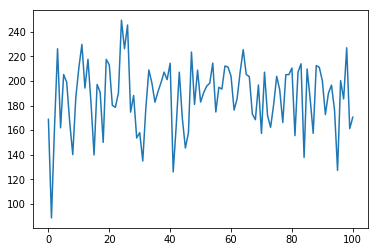

In [331]:
loss_image = "loss_img1"
cps_image = "cps_img1"
pyplot.plot(lh.cps[::50])
pyplot.savefig(cps_image, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)
pyplot.show()

In [332]:
print(scores)

[7.454504287871467, 0.1808472091175278, 175.7566480468976]


In [173]:
print (model.metrics_names)

['loss', 'acc', 'content_pre_score']
